# [Pneumothorax segmentation](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation)

## Author:
## [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan)

## References:

### [Mask RCNN pneumothorax segmentation using transfer learning, Keras implementation](https://www.kaggle.com/hmendonca/top-mask-rcnn-and-coco-transfer-learning)

### Pre-trained weights using [COCO dataset](http://cocodataset.org)

### [Keras implementation of Mask RCNN](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)

#### Note: This notebook is designed to run on [Google Colab](https://colab.research.google.com/) or a cloud environment with [rClone](https://rclone.org/)

In [1]:
import os
import random

In [2]:
! nvidia-smi

Sun Sep  1 08:54:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
setup = False
training_mode = True
positive_sampling = False
stage_2= True
reload_weights = True
debug = False
download_rawData = False
retrain_network = random.SystemRandom().choice([True,
                                                False])
weights_averaging = True
use_best_epoch = False
transfer_learning = False
colab_mode = False

In [4]:
DETECTOR_THRESHOLD = 0.95
EPOCHS = 15
DATA_DIR = '/home/rahulremanan/'
DATA_FILENAME = 'siim-train-test.zip'
DATA_FILE = os.path.join(DATA_DIR, DATA_FILENAME)
ROOT_DIR = '/home/rahulremanan/'
GOOGLE_DRIVE = '/home/rahulremanan/My\ Drive'
RCLONE_DRIVE = 'gdrive'
NETWORK_ID = random.SystemRandom().choice([#'MaskRCNN_ResNet50',
                                           'MaskRCNN_ResNet100'])
NOTEBOOK_ID = 'pneumothorax_{}'.format(NETWORK_ID)
WEIGHTS_FILENAME = '{}.h5'.format(NOTEBOOK_ID)
WEIGHTS_FILE = os.path.join(DATA_DIR, WEIGHTS_FILENAME)
AVERAGED_WEIGHTS_FILENAME = '{}_averaged.h5'.format(NOTEBOOK_ID)
AVERAGED_WEIGHTS_FILE = '{}/{}'.format(DATA_DIR,
                                       AVERAGED_WEIGHTS_FILENAME)
SUBMISSION_FILENAME = 'pneumothorax_stage_2_sample_submission.csv' if stage_2 else 'sample_submission_pneumothorax_segmentation.csv'
SUBMISSION_FILE = os.path.join(DATA_DIR, SUBMISSION_FILENAME)
STAGE_1_TEST_FILENAME = 'pneumothorax_segmentation_dicom_test.zip'
STAGE_1_TRAIN_FILENAME = 'pneumothorax_segmentation_dicom_train.zip'
STAGE_2_TEST_FILENAME = 'pneumothorax_stage_2_test.zip'

In [5]:
if not (NETWORK_ID == 'MaskRCNN_ResNet50' or NETWORK_ID == 'MaskRCNN_ResNet100'):
  raise Exception('NETWORK_ID should be either: {} or {} ...'.format('MaskRCNN_ResNet100', 
                                                                     'MaskRCNN_ResNet50'))
print ('Mask-RCNN network type: {} ...'.format(NETWORK_ID))

Mask-RCNN network type: MaskRCNN_ResNet100 ...


In [6]:
if setup and colab_mode:
  from google.colab import drive
  drive.mount('/content/drive')

In [7]:
if setup:
  ! pip3 install pydicom retrying google-auth sklearn

In [8]:
"""Script to download all instances in a DICOM Store."""
import os
import posixpath
from concurrent import futures
from retrying import retry
import google.auth
from google.auth.transport.requests import AuthorizedSession

# URL of CHC API
CHC_API_URL = 'https://healthcare.googleapis.com/v1beta1'
PROJECT_ID = 'kaggle-siim-healthcare'
REGION = 'us-central1'
DATASET_ID = 'siim-pneumothorax'
TRAIN_DICOM_STORE_ID = 'dicom-images-train'
TEST_DICOM_STORE_ID = 'dicom-images-test'


@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def download_instance(dicom_web_url, dicom_store_id, study_uid, series_uid,
                      instance_uid, credentials):
    """Downloads a DICOM instance and saves it under the current folder."""
    instance_url = posixpath.join(dicom_web_url, 'studies', study_uid, 'series',
                                  series_uid, 'instances', instance_uid)
    authed_session = AuthorizedSession(credentials)
    response = authed_session.get(
        instance_url, headers={'Accept': 'application/dicom; transfer-syntax=*'})
    file_path = posixpath.join(dicom_store_id, study_uid, series_uid,
                               instance_uid)
    filename = '%s.dcm' % file_path
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename))
    with open(filename, 'wb') as f:
        f.write(response.content)


def download_all_instances(dicom_store_id, credentials):
    """Downloads all DICOM instances in the specified DICOM store."""
    # Get a list of all instances.
    dicom_web_url = posixpath.join(CHC_API_URL, 'projects', PROJECT_ID,
                                   'locations', REGION, 'datasets', DATASET_ID,
                                   'dicomStores', dicom_store_id, 'dicomWeb')
    qido_url = posixpath.join(dicom_web_url, 'instances')
    authed_session = AuthorizedSession(credentials)
    response = authed_session.get(qido_url, params={'limit': '15000'})
    if response.status_code != 200:
        print(response.text)
        return
    content = response.json()
    # DICOM Tag numbers
    study_instance_uid_tag = '0020000D'
    series_instance_uid_tag = '0020000E'
    sop_instance_uid_tag = '00080018'
    value_key = 'Value'
    with futures.ThreadPoolExecutor() as executor:
        future_to_study_uid = {}
        for instance in content:
            study_uid = instance[study_instance_uid_tag][value_key][0]
            series_uid = instance[series_instance_uid_tag][value_key][0]
            instance_uid = instance[sop_instance_uid_tag][value_key][0]
            future = executor.submit(download_instance, dicom_web_url, dicom_store_id,
                                     study_uid, series_uid, instance_uid, credentials)
            future_to_study_uid[future] = study_uid
        processed_count = 0
        for future in futures.as_completed(future_to_study_uid):
            try:
                future.result()
                processed_count += 1
                if not processed_count % 100 or processed_count == len(content):
                    print('Processed instance %d out of %d' %
                          (processed_count, len(content)))
            except Exception as e:
                print('Failed to download a study. UID: %s \n exception: %s' %
                      (future_to_study_uid[future], e))


def download_dicomData(argv=None):
    credentials, _ = google.auth.default()
    print('Downloading all instances in %s DICOM store' % TRAIN_DICOM_STORE_ID)
    download_all_instances(TRAIN_DICOM_STORE_ID, credentials)
    print('Downloading all instances in %s DICOM store' % TEST_DICOM_STORE_ID)
    download_all_instances(TEST_DICOM_STORE_ID, credentials)

In [9]:
if download_rawData and not(os.path.exists('./pneumothorax_segmentation_dicom_train.zip')):
  ! gcloud auth application-default login
  download_dicomData()
  ! zip -r -q ./pneumothorax_segmentation_dicom_test.zip ./dicom-images-test/
  ! zip -r -q ./pneumothorax_segmentation_dicom_s_train.zip ./dicom-images-train/

In [10]:
if download_rawData and os.path.exists('./pneumothorax_segmentation_dicom_test.zip') and os.path.exists('./pneumothorax_segmentation_dicom_train.zip'):
  ! cp ./pneumothorax_segmentation_dicom_test.zip {GOOGLE_DRIVE}/
  ! cp ./pneumothorax_segmentation_dicom_train.zip {GOOGLE_DRIVE}/

In [11]:
if download_rawData and not stage_2 and colab_mode:
  ! kaggle datasets download -d seesee/siim-train-test
  ! cp {DATA_FILE} {GOOGLE_DRIVE}/
elif setup and not stage_2 and colab_mode:
  ! cp {GOOGLE_DRIVE}/{DATA_FILENAME} {DATA_DIR}
  print ('Downloaded Stage 1 train and test data ...')
  ! unzip -q {DATA_FILE}
  print ('Unzipped Stage 1 train and test data ...')
elif setup and stage_2 and colab_mode:
  ! cp {GOOGLE_DRIVE}/{STAGE_1_TEST_FILENAME} {DATA_DIR}
  ! cp {GOOGLE_DRIVE}/{STAGE_1_TRAIN_FILENAME} {DATA_DIR}
  ! cp {GOOGLE_DRIVE}/{STAGE_2_TEST_FILENAME} {DATA_DIR}
  print ('Downloaded Stage 2 train and test data ...')
elif setup and stage_2:
  ! rclone copy {RCLONE_DRIVE}:{STAGE_1_TEST_FILENAME} {DATA_DIR}
  ! rclone copy {RCLONE_DRIVE}:{STAGE_1_TRAIN_FILENAME} {DATA_DIR}
  ! rclone copy {RCLONE_DRIVE}:{STAGE_2_TEST_FILENAME} {DATA_DIR}  

In [12]:
if setup and stage_2:
  ! unzip -q {DATA_DIR}/{STAGE_1_TEST_FILENAME} -d {DATA_DIR}
  ! unzip -q {DATA_DIR}/{STAGE_1_TRAIN_FILENAME} -d {DATA_DIR}
  ! cp -r {DATA_DIR}/dicom-images-test/1.* {DATA_DIR}/dicom-images-train/
  ! rm -r {DATA_DIR}/dicom-images-test/
  print ('Processed train data ...')
  ! mkdir {DATA_DIR}/dicom-images-test/
  ! unzip -q {DATA_DIR}/{STAGE_2_TEST_FILENAME} -d {DATA_DIR}/dicom-images-test/
  print ('Processed test data')

In [13]:
if setup or reload_weights or not os.path.exists(WEIGHTS_FILE):
    if colab_mode:
      ! cp {GOOGLE_DRIVE}/{WEIGHTS_FILENAME} {DATA_DIR}
    else:
      ! rclone copy {RCLONE_DRIVE}:{WEIGHTS_FILENAME} {DATA_DIR}
print ('Downloaded {} weights: {} magically from the clouds ...'.format(NETWORK_ID, WEIGHTS_FILENAME))

2019/09/01 08:54:33 ERROR : : error reading source directory: directory not found
2019/09/01 08:54:33 ERROR : Attempt 1/3 failed with 1 errors and: directory not found
2019/09/01 08:54:33 ERROR : : error reading source directory: directory not found
2019/09/01 08:54:33 ERROR : Attempt 2/3 failed with 1 errors and: directory not found
2019/09/01 08:54:33 ERROR : : error reading source directory: directory not found
2019/09/01 08:54:33 ERROR : Attempt 3/3 failed with 1 errors and: directory not found
2019/09/01 08:54:33 Failed to copy: directory not found
Downloaded MaskRCNN_ResNet100 weights: pneumothorax_MaskRCNN_ResNet100.h5 magically from the clouds ...


In [14]:
import sys

import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [15]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            #print (currentColor)
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

In [16]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = []
    for item in rle.split():
      try:
        array.append(int(item))
      except:
        pass
    array = np.asarray(array, dtype=np.int64)

    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        try:
          mask[current_position:current_position+lengths[index]] = 255
        except:
          pass
          #print ('An exception occured')
        try:
          current_position += lengths[index]
        except:
          pass
          #print ('Another exception occured')
    
    return mask.reshape(width, height)

In [17]:
!ls {DATA_DIR}

EfficientNet.zip
Mask_RCNN
Pneumothorax_Classifier.ipynb
Pneumothorax_MaskRCNN.ipynb
Pneumothorax_UNet_EfficientNet.ipynb
UNet_model.h5
UNet_model.json
bayesian_inference.avi
classifier_InceptionResNetV2_swa.model
dicom-images-test
dicom-images-train
efficientnet_
ensemble_MaskRCNN_ResNet100_UNet_768_submission.csv
pneumothorax_MaskRCNN_ResNet100.h5
pneumothorax_MaskRCNN_ResNet50.h5
pneumothorax_classifier_InceptionResNetV2_256.h5
pneumothorax_maskrcnn_resnet10020190831T1324
pneumothorax_maskrcnn_resnet10020190831T1349
pneumothorax_maskrcnn_resnet10020190831T1354
pneumothorax_maskrcnn_resnet5020190831T1317
pneumothorax_maskrcnn_resnet5020190831T1322
pneumothorax_segmentation_dicom_test.zip
pneumothorax_segmentation_dicom_train.zip
pneumothorax_stage_2_sample_submission.csv
pneumothorax_stage_2_test.zip
pneumothorax_stage_2_train.csv.zip
pneumothorax_supercharged_UNet_EfficientNet_hypercolumns_512.h5
pneumothorax_supercharged_UNet_EfficientNet_hypercolumns_768.h5
redis
redis-stable
refe

### Install Matterport's [Keras implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN) model from github.

In [18]:
if setup:  
  # !pip install 'keras==2.1.6' --force-reinstall
  !git clone https://www.github.com/matterport/Mask_RCNN.git
  os.chdir('Mask_RCNN')
  #!python setup.py -q install
  !ls

In [19]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [20]:
train_dicom_dir = os.path.join(DATA_DIR, 'dicom-images-train')
test_dicom_dir = os.path.join(DATA_DIR, 'dicom-images-test')

# count files
!ls -m {train_dicom_dir} | wc
!ls -m {test_dicom_dir} | wc

  12047   12047  678590
    802    3205   57689


### Download COCO pre-trained weights

In [21]:
if setup and transfer_learning:  
  !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
  !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [22]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal

IMAGE_DIM = (1024, 1024)

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = NOTEBOOK_ID
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50' if NETWORK_ID.lower() == 'maskRCNN_ResNet50'.lower() else 'resnet101'
    
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    NUM_CLASSES = 2  # background and pneumothorax classes
    
    IMAGE_MIN_DIM = IMAGE_DIM[0]
    IMAGE_MAX_DIM = IMAGE_DIM[1]
    
    RPN_ANCHOR_SCALES = random.SystemRandom().choice([(64, 128, 256, 512, 1024),
                                                      (16, 32, 64, 128),
                                                      (8, 16, 32, 64)])
    
    TRAIN_ROIS_PER_IMAGE = random.SystemRandom().choice([64,
                                                         128,
                                                         196])
    MAX_GT_INSTANCES = 16
    DETECTION_MAX_INSTANCES = 10 
    DETECTION_MIN_CONFIDENCE = 0.6 if NETWORK_ID.lower() == 'maskRCNN_ResNet50'.lower() else DETECTOR_THRESHOLD
    DETECTION_NMS_THRESHOLD = 0.1 #0.0

    STEPS_PER_EPOCH = 15 if debug else 6884
    VALIDATION_STEPS = 10 if debug else 100
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.6,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 0.1, #1.0
        "mrcnn_mask_loss": 2.4
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.6, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 0.1, 'mrcnn_mask_loss': 2.4}
MASK_POOL_SIZE                 14
MASK_SHAPE       

In [23]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    ''' Encode disconnected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle2mask(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle2mask(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

def masks_as_image(rle_list, shape=IMAGE_DIM):
    # Take the individual masks and create a single mask array
    all_masks = np.zeros(shape, dtype=np.uint8)
    for mask in rle_list:
        if isinstance(mask, str) and mask != '-1':
            all_masks |= rle2mask(mask, shape[0], shape[1]).T.astype(bool)
    return all_masks

def masks_as_color(rle_list, shape=IMAGE_DIM):
    # Take the individual masks and create a color mask array
    all_masks = np.zeros(shape, dtype=np.float)
    scale = lambda x: (len(rle_list)+x+1) / (len(rle_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(rle_list):
        if isinstance(mask, str) and mask != '-1':
            all_masks[:,:] += scale(i) * rle2mask(mask, shape[0], shape[1]).T
    return all_masks

In [24]:
from PIL import Image
from sklearn.model_selection import train_test_split

train_glob = f'{train_dicom_dir}/*/*/*.dcm'
if stage_2:
  test_glob = f'{test_dicom_dir}/*.dcm'
else:  
  test_glob = f'{test_dicom_dir}/*/*/*.dcm'

exclude_list = []
train_names = [f for f in sorted(glob.glob(train_glob)) if f not in exclude_list]
test_names = [f for f in sorted(glob.glob(test_glob)) if f not in exclude_list]

print(len(train_names), len(test_names))
# print(train_names[0], test_names[0])
# !ls -l {os.path.join(train_dicom_dir, train_names[0])}

12047 3205


In [25]:
STAGE_2_SAMPLE_SUBMISSION = 'pneumothorax_stage_2_sample_submission.csv'
if stage_2 and setup and colab_mode:
  ! cp {GOOGLE_DRIVE}/{STAGE_2_SAMPLE_SUBMISSION} {DATA_DIR}
elif stage_2 and setup:
  ! rclone copy {RCLONE_DRIVE}:{STAGE_2_SAMPLE_SUBMISSION} {DATA_DIR}

In [26]:
STAGE_2_SEGMENTATION_FILE = 'pneumothorax_stage_2_train.csv.zip'
if stage_2 and setup and colab_mode:
  ! cp {GOOGLE_DRIVE}/{STAGE_2_SEGMENTATION_FILE} {DATA_DIR}
elif stage_2 and setup:
  ! rclone copy {RCLONE_DRIVE}:{STAGE_2_SEGMENTATION_FILE} {DATA_DIR}
print ('Downloaded segmentation data ...')

Downloaded segmentation data ...


In [27]:
if stage_2 and setup:
  ! unzip -q {DATA_DIR}/{STAGE_2_SEGMENTATION_FILE} -d {DATA_DIR}
  ! chmod 777 {DATA_DIR}/{STAGE_2_SEGMENTATION_FILE}

In [28]:
# training dataset
if stage_2:
  SEGMENTATION_DATA_FILENAME = 'stage_2_train.csv'
  print ('Reading from Stage 2 segmentation data ...')
else:
  SEGMENTATION_DATA_FILENAME = 'train-rle.csv'
  print ('Reading from Stage 1 segmentation data ...')
  
SEGMENTATION = os.path.join(DATA_DIR, SEGMENTATION_DATA_FILENAME)
print (SEGMENTATION)
anns = pd.read_csv(SEGMENTATION)
anns.head()

Reading from Stage 2 segmentation data ...
/home/rahulremanan/stage_2_train.csv


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


In [29]:
# get rid of damn space in column name
anns.columns = ['ImageId', 'EncodedPixels']

In [30]:
# discard healthy patients
unique_anns = anns[anns.EncodedPixels != '-1' if stage_2 else ' -1'].ImageId.unique().tolist()
print('Number of unique annotations: ', len(unique_anns))
train_names = [fp for fp in train_names if fp.split('/')[-1][:-4] in unique_anns]  if positive_sampling else [fp for fp in train_names if fp.split('/')[-1][:-4] in anns.ImageId.unique().tolist()]## override only with pneumothorax
print ('Total number of training images: {} ...'.format(len(train_names)))

Number of unique annotations:  2669
Total number of training images: 12047 ...


## Create train-validation split:

In [31]:
test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
image_fps_train, image_fps_val = train_test_split(train_names, 
                                                  test_size=test_size, 
                                                  random_state=42)

In [32]:
test_image_fps = test_names

if debug:
    print('DEBUG subsampling from:', len(image_fps_train), len(image_fps_val), len(test_image_fps))
    image_fps_train = image_fps_train[:150]
    image_fps_val = image_fps_val[:150]
    test_image_fps = test_names[:150]
    
print(len(image_fps_train), len(image_fps_val), len(test_image_fps))

11847 200 3205


In [33]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumothorax', 1, 'Pneumothorax')
        
        # add images 
        for i, fp in enumerate(image_fps):
            image_id = fp.split('/')[-1][:-4]
            annotations = image_annotations.query(f"ImageId=='{image_id}'")['EncodedPixels']
            self.add_image('pneumothorax', image_id=i, path=fp, 
                           annotations=annotations, 
                           orig_height=orig_height, 
                           orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0 or (count == 1 and annotations.values[0] == '-1' if stage_2 else ' -1'): # empty annotation
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle2mask(a, info['orig_height'], info['orig_width']).T
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [34]:
image_fps, image_annotations = train_names, anns

In [35]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0020) Patient ID                          LO: '17d405a3-a0d2-4901-b33a-63906aa48d9f'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [36]:
# Original image size: 1024 x 1024
ORIG_SIZE = 1024

### Create and prepare the training dataset using the DetectorDataset class.

In [37]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, 
                                image_annotations, 
                                ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 19.2 s, sys: 145 ms, total: 19.4 s
Wall time: 19.3 s


In [38]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, 
                              image_annotations, 
                              ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 370 ms, sys: 4.75 ms, total: 375 ms
Wall time: 337 ms


### Display a random image with bounding boxes

(1024, 1024, 3)
/home/rahulremanan/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5626.1517875189.167474/1.2.276.0.7230010.3.1.3.8323329.5626.1517875189.167473/1.2.276.0.7230010.3.1.4.8323329.5626.1517875189.167475.dcm
[1]


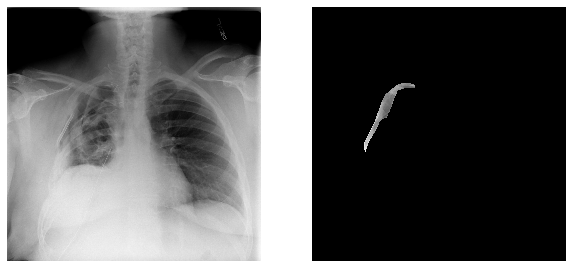

In [39]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_val.image_reference(image_id)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

In [40]:
# Image augmentation (light but constant)
augmentation_1 = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
    iaa.OneOf([
         iaa.Fliplr(1.0),
         iaa.Flipud(1.0),
    ]),
    iaa.OneOf([
         iaa.Affine(
             rotate=(88, 92),
         ),
         iaa.Affine(
             rotate=(178, 182),
         ),
    ]),
])

In [41]:
augmentation_2 = iaa.Sometimes(5/6,
                             iaa.OneOf(
                                            [
                                            iaa.Fliplr(1), 
                                            iaa.Flipud(1), 
                                            iaa.Affine(rotate=(178, 182)), 
                                            iaa.Affine(rotate=(88, 92)), 
                                            iaa.Affine(scale=(0.5, 1.5))
                                             ]
                                        )
                                   )

In [42]:
augmentation = random.SystemRandom().choice([augmentation_1,
                                             augmentation_2])

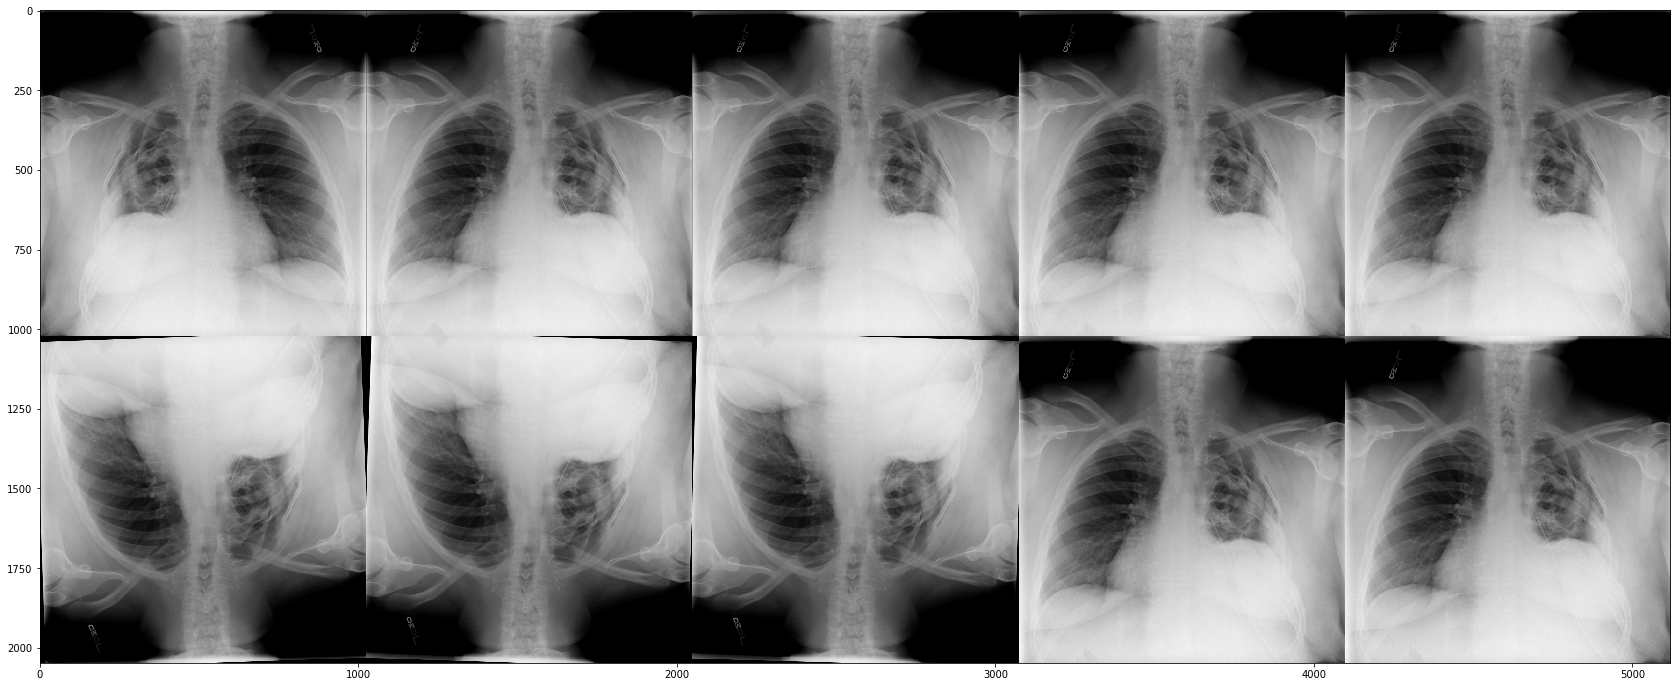

In [43]:
# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [44]:
!nvidia-smi

Sun Sep  1 08:55:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Train the Mask-RCNN model

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [45]:
if training_mode:
  model = modellib.MaskRCNN(mode='training', 
                            config=config, 
                            model_dir=ROOT_DIR)

W0901 08:55:31.232570 140478950872896 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 08:55:31.283305 140478950872896 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0901 08:55:33.873116 140478950872896 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0901 08:55:34.669218 140478950872896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/array_ops.py:1446: where (from tensorflow.python.ops.array_ops) is deprecated and will be remove

In [46]:
# Exclude the last layers because they require a matching
# number of classes
if setup and training_mode and not os.path.exists(WEIGHTS_FILE):
  model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])
  print ('Loaded pre-trained COCO model weights ... ')
elif transfer_learning and training_mode:
  model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])
  print ('Loaded pre-trained COCO model weights ... ')
elif training_mode:
  model.load_weights(WEIGHTS_FILE)
  print ('Loaded pretrained model weights from: {} ...'.format(WEIGHTS_FILE))

Loaded pretrained model weights from: /home/rahulremanan/pneumothorax_MaskRCNN_ResNet100.h5 ...


In [47]:
LEARNING_RATE = 1e-4 #0.003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [48]:
%%time
## train heads with higher lr to speedup the learning
if training_mode:
  model.train(dataset_train, dataset_val,
              learning_rate=LEARNING_RATE*2,
              epochs=2,
              layers='heads' if retrain_network else 'all',
              augmentation= None if retrain_network else augmentation)  ## no need to augment yet

  history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)

W0901 08:55:45.141853 140478950872896 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0901 08:56:08.784408 140478950872896 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/2
6884/6884 [==============================] - 10131s 1s/step - loss: 1.7221 - rpn_class_loss: 0.2416 - rpn_bbox_loss: 0.8474 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.5626 - val_loss: 2.0385 - val_rpn_class_loss: 0.3598 - val_rpn_bbox_loss: 1.0328 - val_mrcnn_class_loss: 0.0666 - val_mrcnn_bbox_loss: 0.0262 - val_mrcnn_mask_loss: 0.5530
Epoch 2/2
6884/6884 [==============================] - 10060s 1s/step - loss: 1.7451 - rpn_class_loss: 0.2848 - rpn_bbox_loss: 0.8406 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.5529 - val_loss: 3.4650 - val_rpn_class_loss: 0.3725 - val_rpn_bbox_loss: 2.5054 - val_mrcnn_class_loss: 0.0424 - val_mrcnn_bbox_loss: 0.0319 - val_mrcnn_mask_loss: 0.5127
CPU times: user 2h 14min 9s, sys: 1h 12min 1s, total: 3h 26min 11s
Wall time: 5h 39min 16s


In [49]:
%%time
## train heads with higher lr to speedup the learning
if training_mode and not debug:
  model.train(dataset_train, dataset_val,
              learning_rate=LEARNING_RATE*2,
              epochs= 3 if debug else EPOCHS//2,
              layers='all',
              augmentation=augmentation)

  new_history = model.keras_model.history.history
  for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.0002

Checkpoint Path: /home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)

In [50]:
%%time
if training_mode:
  model.train(dataset_train, dataset_val,
              learning_rate=LEARNING_RATE,
              epochs=4 if debug else EPOCHS,
              layers='all',
              augmentation=augmentation)

  new_history = model.keras_model.history.history
  for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 7. LR=0.0001

Checkpoint Path: /home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)

Process ForkPoolWorker-37:
Process ForkPoolWorker-34:
Process ForkPoolWorker-39:
Process ForkPoolWorker-33:
Process ForkPoolWorker-38:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Process ForkPoolWorker-35:
Process ForkPoolWorker-40:
Process ForkPoolWorker-43:
Process ForkPoolWorker-41:
Traceback (most recent call last):
Process ForkPoolWorker-44:
Process ForkPoolWorker-45:
Process ForkPoolWorker-42:
Process ForkPoolWorker-48:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-47:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiproces

Epoch 8/15

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 641, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/rahulremanan/Mask_RCNN/mrcnn/model.py", line 1772, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/usr/lib/python3.6/multiprocessing/synchronize.py",

Epoch 8/15

KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
W0902 05:33:33.390734 140478950872896 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



KeyboardInterrupt: 

Process ForkPoolWorker-58:
Process ForkPoolWorker-53:
Process ForkPoolWorker-64:
Process ForkPoolWorker-55:
Process ForkPoolWorker-54:
Process ForkPoolWorker-63:
Process ForkPoolWorker-50:
Process ForkPoolWorker-51:
Process ForkPoolWorker-52:
Traceback (most recent call last):
Process ForkPoolWorker-59:
Process ForkPoolWorker-62:
Process ForkPoolWorker-49:
Process ForkPoolWorker-61:
Process ForkPoolWorker-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-56:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.r

In [54]:
def weights_average(weights_files, 
                    model=None, 
                    file_path='averaged_weights.h5'):
  for i in range(len(weights_files)-1):
    if i == 0 and model is not None:
      model.load_weights(weights_files[i],
                                       by_name=True)
      model_weights = model.get_weights()
      model.load_weights(weights_files[i+1],
                         by_name=True)
      next_model_weights = model.get_weights()
      for i, layer in enumerate(model.layers):
        model_weights[i] = (model_weights[i] + next_model_weights[i])/2
      model.set_weights(model_weights)
      model.save_weights(file_path)
    elif os.path.exists(file_path) and model is not None:
      model.load_weights(file_path,
                         by_name=True)
      averaged_weights = model.get_weights()
      model.load_weights(weights_files[i+1],
                         by_name=True)
      next_model_weights = model.get_weights()
      for i, layer in enumerate(model.layers):
        averaged_weights[i] = (averaged_weights[i] + next_model_weights[i])/2
      model.set_weights(averaged_weights)
      model.save_weights(file_path)
  return True

In [55]:
if training_mode and weights_averaging:  
  weights_files = []
  if os.path.exists(WEIGHTS_FILE):
    weights_files.append(WEIGHTS_FILE)
  # select trained model 
  dir_names = next(os.walk(model.model_dir))[1]
  key = config.NAME.lower()
  dir_names = filter(lambda f: f.startswith(key), 
                     dir_names)
  dir_names = sorted(dir_names)

  if not dir_names:
      import errno
      raise FileNotFoundError(
          errno.ENOENT,
          "Could not find model directory under {}".format(model_dir))

  fps = []
  # Pick last directory
  try:
    for d in dir_names: 
        dir_name = os.path.join(model.model_dir, d)
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), \
                             checkpoints)
        checkpoints = sorted(checkpoints)
        print ('Found {} model weights ...'.format(len(checkpoints)))
        for checkpoint in checkpoints:
          weights_files.append(os.path.join(dir_name, checkpoint))
  except:
    pass

Found 0 model weights ...
Found 0 model weights ...
Found 2 model weights ...
Found 7 model weights ...


In [56]:
if training_mode and weights_averaging:
  print (weights_files)
  weights_average(weights_files=weights_files, 
                  model=model.keras_model, 
                  file_path=AVERAGED_WEIGHTS_FILE)

['/home/rahulremanan/pneumothorax_MaskRCNN_ResNet100.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190831T1354/mask_rcnn_pneumothorax_maskrcnn_resnet100_0001.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190831T1354/mask_rcnn_pneumothorax_maskrcnn_resnet100_0003.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0001.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0002.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0003.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0004.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0005.h5', '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0006.h5', '/home

In [57]:
if training_mode:
  epochs = range(1, len(history['loss'])+1)
  pd.DataFrame(history, index=epochs)

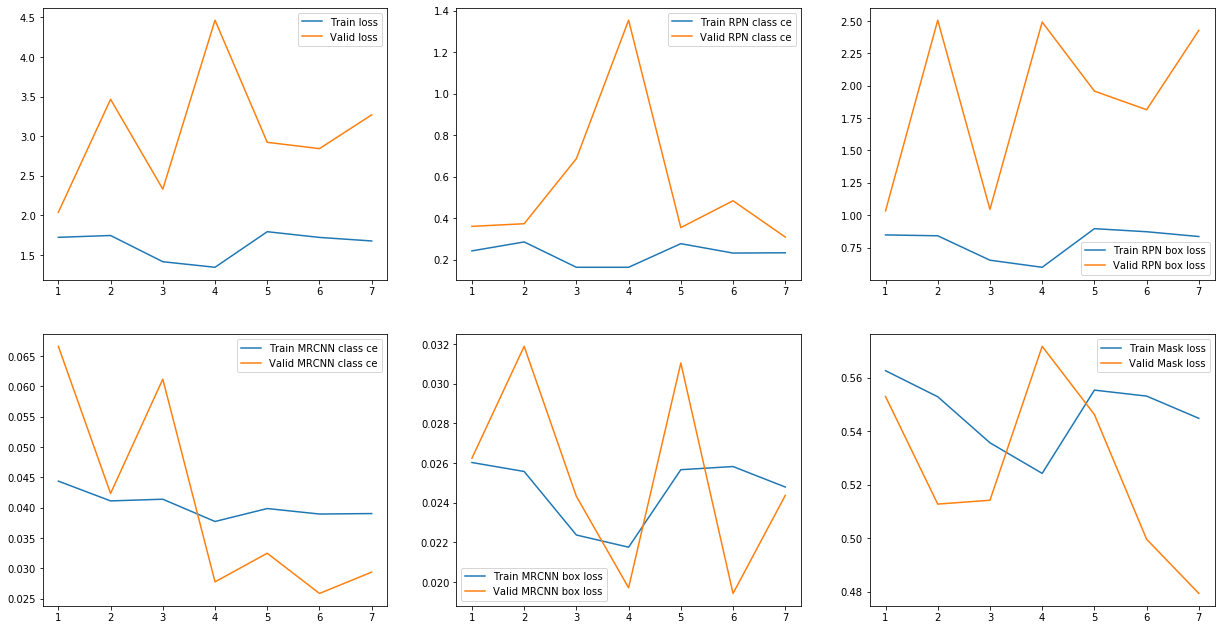

In [58]:
if training_mode:
  plt.figure(figsize=(21,11))

  plt.subplot(231)
  plt.plot(epochs, history["loss"], label="Train loss")
  plt.plot(epochs, history["val_loss"], label="Valid loss")
  plt.legend()
  plt.subplot(232)
  plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
  plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
  plt.legend()
  plt.subplot(233)
  plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
  plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
  plt.legend()
  plt.subplot(234)
  plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
  plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
  plt.legend()
  plt.subplot(235)
  plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
  plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
  plt.legend()
  plt.subplot(236)
  plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
  plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
  plt.legend()

  plt.show()

In [59]:
if training_mode:
  best_epoch = np.argmin(history["val_loss"])
  score = history["val_loss"][best_epoch]
  print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:1 val_loss:2.038530955314636


In [60]:
if training_mode:
  # select trained model 
  dir_names = next(os.walk(model.model_dir))[1]
  key = config.NAME.lower()
  dir_names = filter(lambda f: f.startswith(key), 
                     dir_names)
  dir_names = sorted(dir_names)

  if not dir_names:
      import errno
      raise FileNotFoundError(
          errno.ENOENT,
          "Could not find model directory under {}".format(self.model_dir))

  fps = []
  # Pick last directory
  try:
    for d in dir_names: 
        dir_name = os.path.join(model.model_dir, d)
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), 
                             checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            print('No weight files in {}'.format(dir_name))
        else:
            checkpoint = os.path.join(dir_name, 
                                      checkpoints[best_epoch])
            fps.append(checkpoint)

    model_path = sorted(fps)[-1]
    print('Found model {}'.format(model_path))
  except:
    model_path = WEIGHTS_FILE
    print ('Best model path: {} ...'.format(model_path))

No weight files in /home/rahulremanan/pneumothorax_maskrcnn_resnet10020190831T1324
No weight files in /home/rahulremanan/pneumothorax_maskrcnn_resnet10020190831T1349
Found model /home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0001.h5


In [107]:
use_best_epoch = False

In [108]:
if use_best_epoch and training_mode:
  model_path = model_path
  print ('Saving model file: {}'.format(model_path))
elif weights_averaging and training_mode and os.path.exists(AVERAGED_WEIGHTS_FILE):
  model_path = AVERAGED_WEIGHTS_FILE
  print ('Saving model file: {}'.format(model_path))

Saving model file: /home/rahulremanan//pneumothorax_MaskRCNN_ResNet100_averaged.h5


In [133]:
model_path = '/home/rahulremanan/pneumothorax_maskrcnn_resnet10020190901T0855/mask_rcnn_pneumothorax_maskrcnn_resnet100_0006.h5'

In [134]:
if training_mode:
  ! mv {model_path} {WEIGHTS_FILE}

In [135]:
if training_mode and colab_mode:
  ! cp {WEIGHTS_FILE} {GOOGLE_DRIVE}/
  ! cp {AVERAGED_WEIGHTS_FILE} {GOOGLE_DRIVE}/
elif training_mode:
  ! rclone copy {WEIGHTS_FILE} {RCLONE_DRIVE}: -v
  ! rclone copy {AVERAGED_WEIGHTS_FILE} {RCLONE_DRIVE}: -v
print ('Saved model weights: {} to the cloud...'.format(model_path))

2019/09/02 07:16:25 INFO  : pneumothorax_MaskRCNN_ResNet100.h5: Copied (replaced existing)
2019/09/02 07:16:25 INFO  : 
Transferred:   	  244.005M / 244.005 MBytes, 100%, 24.332 MBytes/s, ETA 0s
Errors:                 0
Checks:                 0 / 0, -
Transferred:            1 / 1, 100%
Elapsed time:         10s

2019/09/02 07:16:27 ERROR : : error reading source directory: directory not found
2019/09/02 07:16:27 INFO  : Google drive root '': Waiting for checks to finish
2019/09/02 07:16:27 INFO  : Google drive root '': Waiting for transfers to finish
2019/09/02 07:16:27 ERROR : Attempt 1/3 failed with 1 errors and: directory not found
2019/09/02 07:16:28 ERROR : : error reading source directory: directory not found
2019/09/02 07:16:28 INFO  : Google drive root '': Waiting for checks to finish
2019/09/02 07:16:28 INFO  : Google drive root '': Waiting for transfers to finish
2019/09/02 07:16:28 ERROR : Attempt 2/3 failed with 1 errors and: directory not found
2019/09/02 07:16:29 ERROR

### Prepare the Mask-RCNN model for inference

In [136]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

In [137]:
# Load trained weights (fill in path to trained weights here)
try:
  assert model_path != "", "Provide path to trained weights"
  model.load_weights(model_path, by_name=True)
  print("Loaded weights from ", model_path)
except:
  model.load_weights(WEIGHTS_FILE, by_name=True)
  print ("Loaded weights from ", WEIGHTS_FILE)

Loaded weights from  /home/rahulremanan/pneumothorax_MaskRCNN_ResNet100.h5


In [138]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### Comparing predictions to the expected values 
Generating comparison between the prediction masks and the expected masks, using the validation dataset. 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



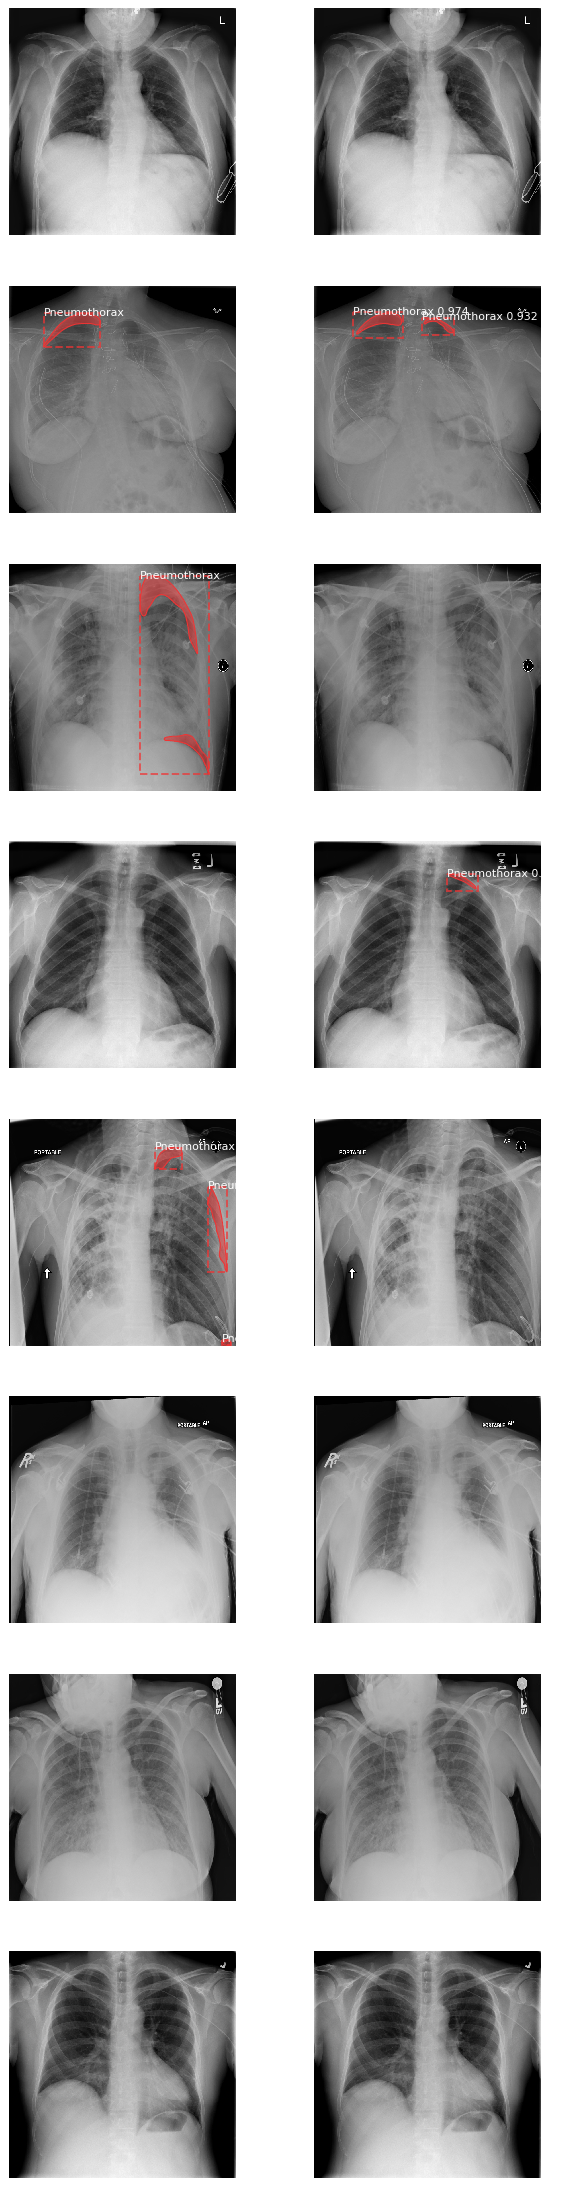

In [139]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, 
                               inference_config, 
                               image_id, 
                               use_mini_mask=False)
    
    # print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, 
                                gt_bbox, 
                                gt_mask, 
                                gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), 
                                ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, 
                                r['rois'], 
                                r['masks'], 
                                r['class_ids'], 
                                dataset.class_names, 
                                r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), 
                                ax=fig.axes[-1])

In [140]:
if (setup or not os.path.exists(SUBMISSION_FILE)) and colab_mode:
  ! cp {GOOGLE_DRIVE}/{SUBMISSION_FILENAME} {DATA_DIR}
elif (setup or not os.path.exists(SUBMISSION_FILE)):
  ! rclone copy {RCLONE_DRIVE}:{SUBMISSION_FILE} {DATA_DIR}

### Final steps - Create the filtered submission file

In [141]:
sub = pd.read_csv(SUBMISSION_FILE)

tmp = sub.groupby('ImageId')['ImageId'].count().reset_index(name='N')
tmp = tmp.loc[tmp.N >= 1 if stage_2 else tmp.N > 1 ] #find image id's with more than 1 row -> has pneumothorax mask!

possible_patients = tmp.ImageId.values

In [142]:
print ('Number of possible patients: {} ...'.format(len(possible_patients)))

Number of possible patients: 3205 ...


In [143]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission_maskRCNN_ResNet100.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for fp in tqdm(image_fps):
            #print (fp)
            image_id = fp.split('/')[-1][:-4]
            found = False
            
            if image_id in possible_patients:
                ds = pydicom.read_file(fp)
                image = ds.pixel_array
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
                image, window, scale, padding, crop = utils.resize_image(
                    image,
                    min_dim=config.IMAGE_MIN_DIM,
                    min_scale=config.IMAGE_MIN_SCALE,
                    max_dim=config.IMAGE_MAX_DIM,
                    mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]

                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass ## no pneumothorax; '-1' written below
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf and np.sum(r['masks'][...,i]) > 1:
#                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.max(r['masks'][...,i]))
#                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                            file.write(image_id + "," + mask2rle(r['masks'][...,i].T*255, IMAGE_DIM[0], IMAGE_DIM[1]) + "\n")
                            found = True

            if not found:
                file.write(image_id + ",-1\n")  ## no pneumothorax

In [144]:
submission_fp = os.path.join(ROOT_DIR, 'submission_{}.csv'.format(NOTEBOOK_ID))
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3205/3205 [17:03<00:00,  3.13it/s]

/home/rahulremanan/submission_pneumothorax_MaskRCNN_ResNet100.csv


In [145]:
sub = pd.read_csv(submission_fp)
print(sub.EncodedPixels.isnull().sum(), sub.ImageId.nunique(), sub.EncodedPixels.isnull().sum()/sub.ImageId.nunique())
sub.head(50)

0 3205 0.0


,ImageId,EncodedPixels
0,ID_0011fe81e,-1
1,ID_003206608,-1
2,ID_004d6fbb6,-1
3,ID_004d72c54,-1
4,ID_00528aa0e,-1
5,ID_00593ac6d,-1
6,ID_00b0e5a9f,-1
7,ID_00b115bfe,-1
8,ID_00d054471,-1
9,ID_00f04769e,-1


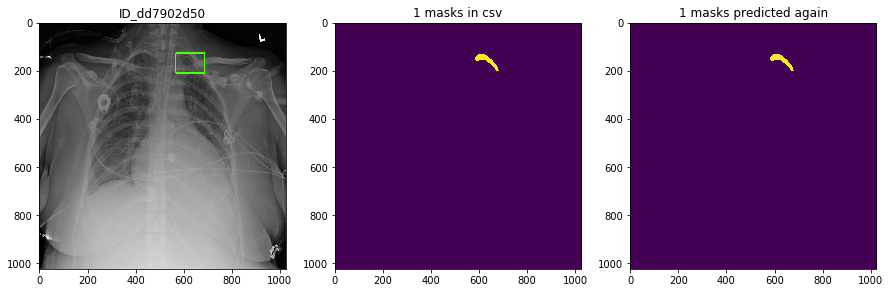

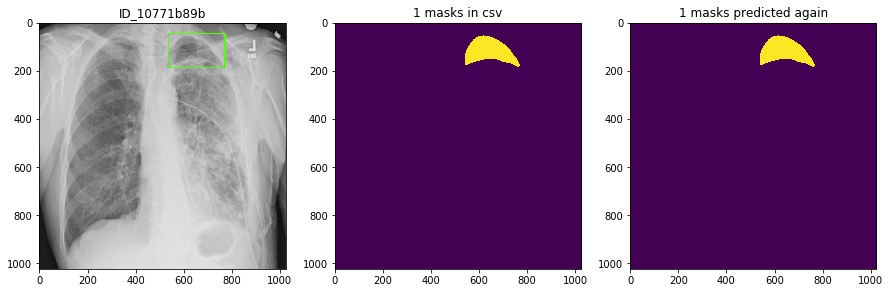

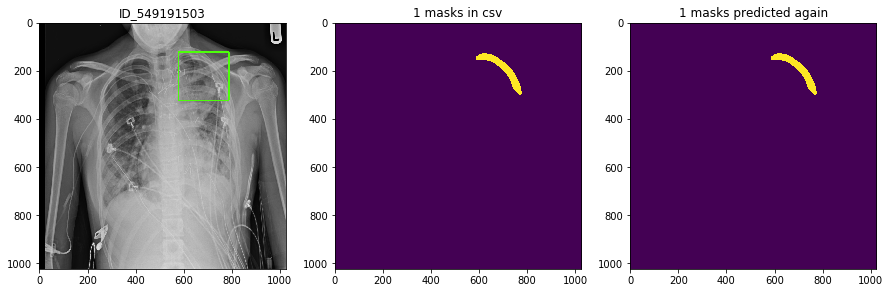

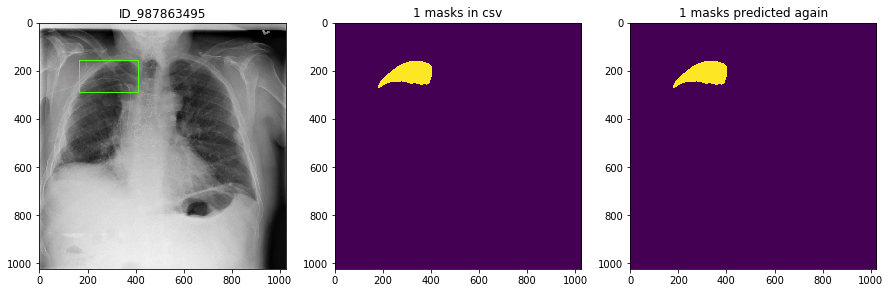

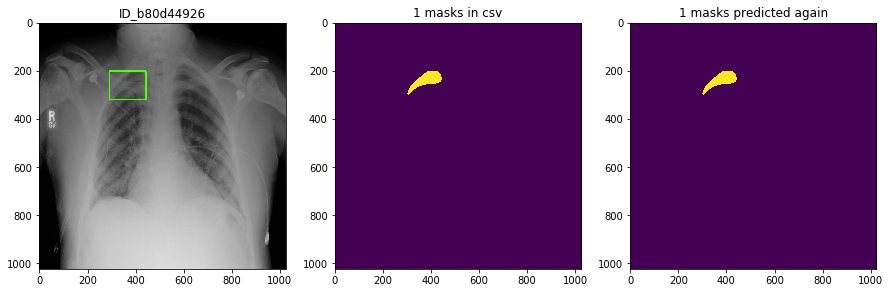

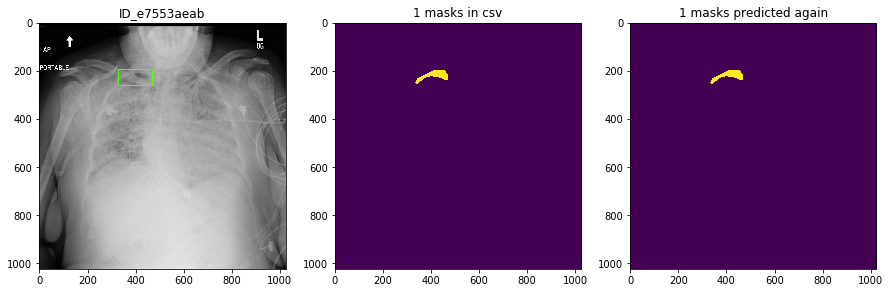

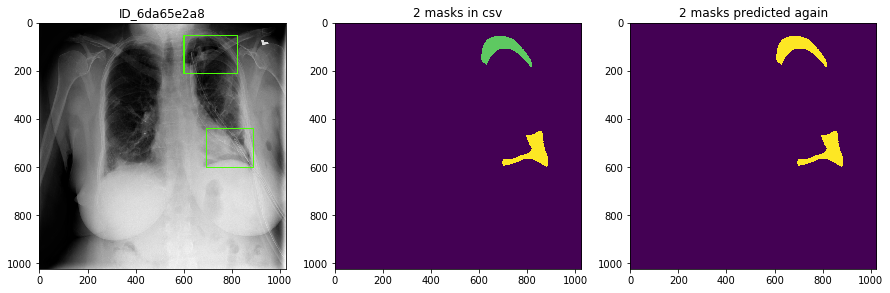

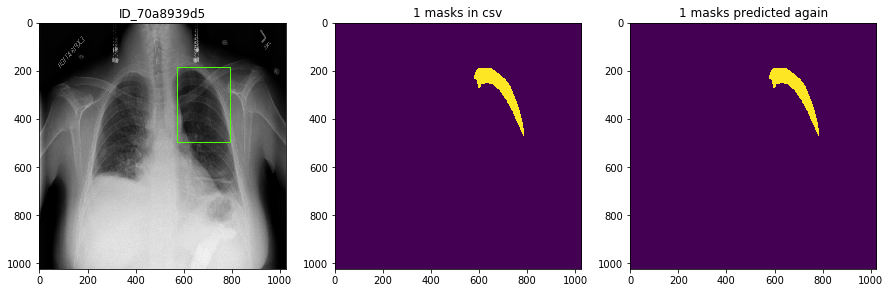

In [146]:
# show a few test image detection example
def visualize_test():
    ids_with_mask = sub[sub.EncodedPixels != '-1'].ImageId.values
    fp = random.choice([fp for fp in test_image_fps if fp.split('/')[-1][:-4] in ids_with_mask])
#     import pdb; pdb.set_trace()
    
    # original image
    image_id = fp.split('/')[-1][:-4]
    ds = pydicom.read_file(fp)
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1
        height = y2 - y1
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.set_title(image_id)
    ax1.imshow(image)
    ax2.set_title(f"{np.count_nonzero(image_id == ids_with_mask)} masks in csv")
    ax2.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels'].values, IMAGE_DIM))
    ax3.set_title(f"{len(r['rois'])} masks predicted again")
    ax3.imshow(r['masks'].max(-1))  # get max (overlap) between all masks in this prediction
#     print(f"ImageId=='{image_id}'", sub.query(f"ImageId=='{image_id}'")['EncodedPixels'])

for i in range(8):
    visualize_test()

In [147]:
# ! mkdir /root/.kaggle/
# ! mv /content/kaggle.json /root/.kaggle/

In [148]:
#!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f {submission_fp} -m "Keras Mask RCNN"

In [125]:
if colab_mode:
    from google.colab import files
    files.download(submission_fp)

In [ ]:
! rm -r /content/pneumothorax*/